In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from scipy import fftpack
from scipy import ndimage
from pysptools.eea import nfindr
import pysptools.abundance_maps as amp
#import eea
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import decomposition
from sklearn.decomposition import NMF
from skimage import morphology
from skimage import filters
from skimage import segmentation
from skimage import transform
from skimage.feature import blob_dog
from glob import glob

## CODE FROM Roma Vasudevan for slidding FFT - work presented here: https://aip.scitation.org/doi/abs/10.1063/1.4914016
I claim none of the functions in this cell to be my own, though they did need revision to work in this use case. I still only adapted them from his original code and I do not present any of the functions below to be part of my project beyond a being a necessary preprocessing step to try to segment images

In [42]:
# CODE FROM Roma Vasudevan for slidding FFT - work presented here: https://aip.scitation.org/doi/abs/10.1063/1.4914016
#I claim none of the functions in this cell to be my own though I did edit them

def ApplyHamming(imgsrc,window_size):
    #Applies a Hamming window to the input imgsec, returns the window after filter applied.
    bw2d = np.outer(np.hamming(window_size), np.ones(window_size))
    bw2d = np.sqrt(bw2d * bw2d.T)
    imgsrc *= bw2d
    return imgsrc

def MakeWindow(imgsrc, xpos, ypos,window_size):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

def GenerateXYPos(window_size, window_step, image_width):
    #Generates the (x,y) pairs given the window size, window step and image width (=height)
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
    num_steps = len(xpos_vec)
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))

    return pos_mat

def zoom_interpol(FFT_image,window_size,FFT_zoom_factor, interpol_factor):
    #Accepts an image, returns zoomed image
    zoom_size = (FFT_image.shape[0]/FFT_zoom_factor)/2
    if np.mod(FFT_image.shape[0]/FFT_zoom_factor,2)==0:
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2 + zoom_size),
                             int(window_size/2 - zoom_size):int(window_size/2 +zoom_size)]
    else:
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2+1 + zoom_size),
                             int(window_size/2 - zoom_size):int(window_size/2 + 1+zoom_size)]

    return ndimage.zoom(F2_zoomed,interpol_factor)

def Do_Sliding_FFT(raw_image,pos_mat,window_size,interpol_factor,FFT_zoom_factor,hamming_filter):
    #Carries out the FFT
    FFT_mat4 = np.zeros(shape = (len(pos_mat),
                                 int(window_size*interpol_factor/FFT_zoom_factor),
                                 int(window_size*interpol_factor/FFT_zoom_factor)))

    for i in np.arange(0,len(pos_mat)):

        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1],window_size) #Generate the window on which FFT is performed

        #Pass the x and y positions of the top-left corner of the FFT window
        #These positions are located in pos_mat

        if hamming_filter ==1: #Apply filter if requested
            img_window_filtered = ApplyHamming(np.copy(img_window),window_size)
        else:
            img_window_filtered = (np.copy(img_window))

        # Take the fourier transform of the image.
        F1 = fftpack.fft2((img_window_filtered))

        # Now shift so that low spatial frequencies are in the center.
        F2 = (fftpack.fftshift((F1)))

        final_FFT = zoom_interpol(np.abs(F2),window_size,FFT_zoom_factor,interpol_factor)

        FFT_mat4[i,:,:,] = final_FFT

    return FFT_mat4


def analyze_endmembers(FFT_mat, num_comp):
    #Determines endmembers given the 3D FFT matrix.
    #Analyzes results by NFINDR
    #Plots the results and saves to .png files


    #Find endmembers and abundance maps
    #Number of endmembers

    q = FFT_mat.shape
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]

    data_mat3 = np.abs(FFT_mat.reshape((a*b, c*d)))

    nnls = amp.NNLS()
    a1 = nfindr.NFINDR(data_mat3, num_comp) #Find endmembers
    endmembers = a1[0]

    data_mat3 = data_mat3.reshape((a,b, c*d))
    amap = nnls.map(data_mat3, endmembers) #Find abundances

    return amap



## My own code:

Determing the thresholds and morphological functions to use was done in the file experimentation.ipynb. Also sorry the experimentation file is a horrible tangled up nightmare of code

In [78]:
def run_sfft(raw_image):
    """Function to run slidding FFT on an image. Outputs an abundance map of shape (m,n,p,3)"""
    num_of_comp = 3
    hamming_filter = 1 
    FFT_zoom_factor = 1
    interpol_factor = 1
    window_size = 64
    window_step = 16
    pos_mat = GenerateXYPos(window_size, window_step, raw_image.shape[0]) #Generate matrix with (x,y) locations of window position
    FFT_mat4 = Do_Sliding_FFT(raw_image,pos_mat,window_size,interpol_factor,FFT_zoom_factor,hamming_filter) #Do the Sliding FFT
    FFT_mat5 = FFT_mat4.reshape(int(np.sqrt(FFT_mat4.shape[0])),
                                        int(np.sqrt(FFT_mat4.shape[0])),
                                        int(window_size*interpol_factor/FFT_zoom_factor),
                                        int(window_size*interpol_factor/FFT_zoom_factor))


    amap = analyze_endmembers(FFT_mat5, num_of_comp)
    return amap

In [79]:
def sfft_filter(sfft,upper = 0.87,lower = 0.1):
    """Function to threshold and apply morphological functions to an accumulation map of an image after going
    through slidding fourier filtering. Returns a binary image or shape (1024,1024). The variables upper and lower
    refer to thresholds for determining regions that should be included as particle regions from the 
    accumulation map"""
    thres1 = filters.threshold_otsu(sfft[:,:,1])
    thres2 = filters.threshold_otsu(sfft[:,:,2])
    if thres1 < thres2:
        image = np.flipud(np.rot90(sfft[:,:,1]))
    else:
        image = np.flipud(np.rot90(sfft[:,:,2]))
    image[image>upper] =1 
    image[image<lower] = 1
    image[image!=1] = 0 
    image = segmentation.clear_border(morphology.dilation(morphology.erosion(morphology.closing(image))))
    image = transform.resize(image,(1024,1024))
    return image

In [1]:
def sfft_pipeline(directory,start = 0,number_images =10,upper = 0.87,lower = 0.1):
    """Wrapper function to go through a file of atomic resolution images of nanoparticles and segement out regions
    which contain nanoparticles. Section of a directory of images can be indicated by start and number of images
    both integers.The variables upper and lower refer to thresholds for determining regions 
    that should be included as particle regions from the accumulation map."""
    if os.path.isdir(directory+'/images/') == False:
        raise \
        RuntimeError('Current directory must have images placed in a directory labeled images')
    image_file_list = glob(directory+'/images/*.png')[start:start+number_images]
    if len(image_file_list) == 0:
        raise RuntimeError('No images found. All images must be in png format')
    image_new_directory = directory + '/segmented_images/'
    if os.path.isdir(image_new_directory) != True:
        os.mkdir(image_new_directory)
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_file_list]
    blob_dict = {}
    for idx, image_file in enumerate(image_file_list):
        image = io.imread(image_file,as_grey=True)
        if image.shape != (1024,1024):
            raise \
            RuntimeError('Images are not of shape (1024,1024) please resize and try again.\
                         File causing error {}'.format(image_name_list[idx]))
        sfft = run_sfft(image)
        binary_image = sfft_filter(sfft,upper,lower)
        blobs = blob_dog(binary_image, max_sigma=60, min_sigma=50, threshold=.5)
        blobs[:, 2] = blobs[:, 2] * np.sqrt(2)
        blob_dict[image_name_list[idx]] = blobs
        for idx2, blob in enumerate(blobs):
            x = int(blob[0])
            y = int(blob[1])
            r = int(blob[2])
            if x - r < 0 or y - r < 0:
                pass
            elif x+r > 1023 or y+r > 1023:
                pass
            else:
                plt.imsave(image_new_directory+image_name_list[idx]+'_'+str(idx2),image[x-r:x+r,y-r:y+r],cmap = 'gray')
    return blob_dict

In [83]:
directory = os.getcwd()+'/rf_data'
blob_dict = sfft_pipeline(directory)

/Users/cgroschner/Documents/pythonLearn/groschner-python-ay250-homework/final_project/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Wooo! A correctly segmented region!
See below

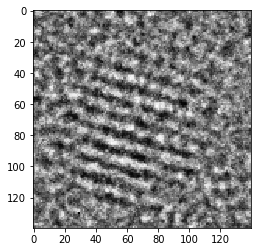

In [84]:
plt.imshow(io.imread(directory+'/segmented_images/101729F_plasma15sec_Mh370kx__0007_1.png'))

## Sometimes it just segments out empty space though :(
See below. This is probably ok because the random forest classifier is very good at telling apart a particle from empty space.

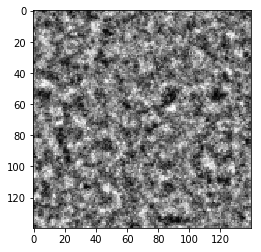

In [85]:
plt.imshow(io.imread(directory+'/segmented_images/101729F_plasma15sec_Mh370kx__0000_1.png'))